# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import functional as F
from torchvision.transforms import AutoAugmentPolicy, AutoAugment

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd

from PIL import Image

from dataclasses import dataclass

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter

import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
DEBUG = True
CREATE_SMALL_IMAGES = False

data_root = '/kaggle/input/opencv-pytorch-dl-course-classification/'

## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [22]:
class KenyanFood13Dataset(Dataset):
    def __init__(self, train_config: None, sys_config: None, train=True, presized=False):
        self.presized = presized
        self.data_root = train_config.data_root
        self.image_shape = train_config.image_shape
        self.transform = train_config.transforms
        data_csv_path = os.path.join(self.data_root, "train.csv")
        data_csv = pd.read_csv(data_csv_path, delimiter=',', engine='python')
        self.targets = data_csv['class']
        self.labels = list(set(self.targets))
        self.labels.sort()
        target_counts = np.unique(self.targets, return_counts=True)
        target_counts_ordered = [target_counts[1][list(target_counts[0]).index(name)] for name in self.labels]
        self.weights = [float(len(self.targets)/count) for count in target_counts_ordered]
        
        X_train, X_test, y_train, y_test = train_test_split(data_csv['id'], self.targets, stratify=self.targets, 
                                                            test_size=train_config.test_size, random_state=sys_config.seed)
        self.data_dict = {}
        
        if train:
            self.data_dict['image_name'] = list(X_train.astype(str))
            if self.presized:
                self.data_dict['image'] = [Image.open(os.path.join(train_config.small_images_path, image_name + ".jpg")) for image_name in self.data_dict['image_name']]
            self.data_dict['label'] = list(y_train)
            self.data_dict['label_idx'] = [self.labels.index(i) for i in list(y_train)]
        else:
            self.data_dict['image_name'] = list(X_test.astype(str))
            if self.presized:
                self.data_dict['image'] = [Image.open(os.path.join(train_config.small_images_path, image_name + ".jpg")) for image_name in self.data_dict['image_name']]
            self.data_dict['label'] = list(y_test)
            self.data_dict['label_idx'] = [self.labels.index(i) for i in list(y_test)]
            
    def __len__(self):
        return len(self.data_dict['label'])
    
    def __getitem__(self, idx):
        image_name = self.data_dict['image_name'][idx]
        
        if not self.presized:
            image_path = os.path.join(self.data_root, "images/images", image_name + '.jpg')
            image = Image.open(image_path)
        else: 
            image = self.data_dict['image'][idx]
        
        if self.image_shape is not None:
            image = F.resize(image, self.image_shape)
        
        if self.transform is not None:
            image = self.transform(image)
            
        image_class_name = self.data_dict['label'][idx]
        target = self.labels.index(image_class_name)
        
        return image, target

In [ ]:
class KenyanFood13DatasetSubmission(Dataset):
    def __init__(self, train_config: None, sys_config: None, train=True):
        self.data_root = train_config.data_root
        self.image_shape = train_config.image_shape
        self.transform = train_config.transforms
        data_csv_path = os.path.join(self.data_root, "test.csv")
        data_csv = pd.read_csv(data_csv_path, delimiter=',', engine='python')
        
        self.data_dict = {}
        self.data_dict['image_name'] = list(data_csv['id'].astype(str))
        self.data_dict['image'] = [Image.open(os.path.join(train_config.small_images_path, image_name + ".jpg")) for image_name in self.data_dict['image_name']]
        
    def __len__(self):
        return len(self.data_dict['image_name'])
    
    def __getitem__(self, idx):
        image = self.data_dict['image'][idx]
        
        if False and self.image_shape is not None:
            image = F.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        return image, 0

In [6]:
def get_data(train_config: None, system_config: None):

    mean, std = get_mean_std(train_config, system_config)
    
    common_transforms = image_common_transforms(mean, std)
    
    # If data_augmentation is True:
    if train_config.data_augmentation:
        train_transforms = data_augmentation_preprocess(mean, std)
    # Else do common tranforms:
    else:
        train_transforms = common_transforms
    
    # Train dataloader
    train_config.transforms = train_transforms
    train_dataset = KenyanFood13Dataset(train_config=train_config, sys_config=system_config, train=True, presized=True)
    train_config.weights = torch.tensor(train_dataset.weights)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config.batch_size, 
                                               num_workers=train_config.num_workers, shuffle=train_config.data_loader_shuffle)
    # Test dataloader
    train_config.transforms = common_transforms
    test_dataset = KenyanFood13Dataset(train_config=train_config, sys_config=system_config, train=False, presized=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=train_config.batch_size, 
                                              num_workers=train_config.num_workers, shuffle=False)
    
    return train_loader, test_loader

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/pytorch-opencv-course-classification/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [7]:
@dataclass
class SystemConfiguration:
    """
    Describes the common system setting needed for reproducible training.
    """
    seed: int = 42 # seed number to set the state of all random number generators.
    cuddn_benchmark_enabled: bool = True # enable CuDNN benchmark for the sake of performance.
    cuddn_deterministic: bool = True # make cudnn deterministic (reproducible training)    

In [8]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cuddn_deterministic

In [13]:
@dataclass
class TrainingConfiguration:
    """
    Describes configuration of the training process
    """
    train_loader: torch.utils.data.DataLoader = None
    test_loader: torch.utils.data.DataLoader = None
    data_loader_shuffle = True
    model: nn.Module = None
    optimizer: torch.optim.Optimizer = None
    batch_size: int = 16 
    epochs_count: int = 100  
    early_stopping_boarder = 5
    early_stopping = False
    learning_rate_scheduler = None
    init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
    log_interval: int = 1  
    test_interval: int = 1  
    data_root: str = data_root 
    num_workers: int = 2  
    device: str = 'cuda'
    transfer_learning = False
    num_classes: int = 13
    transforms = None
    image_shape = (227, 227)
    small_images_path = "/kaggle/working/small_images/"
    test_size: float = 0.2
    tb_writer: SummaryWriter = None
    data_augmentation: bool = True

In [12]:
# Create small images
if CREATE_SMALL_IMAGES:
    images_path = os.path.join(TrainingConfiguration.data_root, "images", "images")
    if not os.path.exists("small_images"):
        os.makedirs("small_images")
        
    for image_name in os.listdir(images_path):
        image = Image.open(os.path.join(images_path, image_name))
        image = image.resize(size=TrainingConfiguration.image_shape, resample=Image.Resampling.LANCZOS)
        image.save(os.path.join("small_images", image_name))        

Length of dataset: 5228, class_name: 3


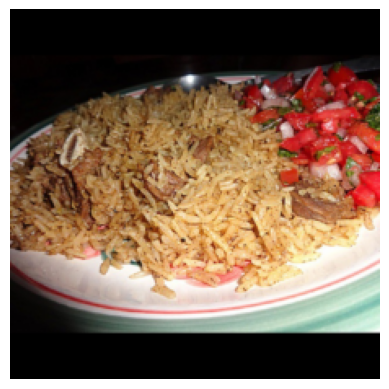

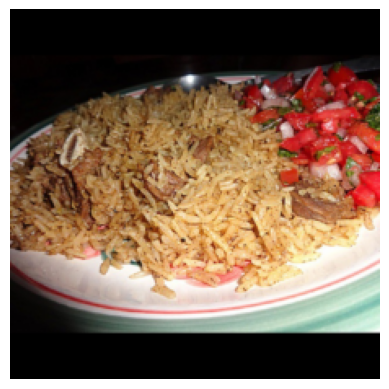

6 
 ['bhaji', 'chapati', 'githeri', 'kachumbari', 'kukuchoma', 'mandazi', 'masalachips', 'matoke', 'mukimo', 'nyamachoma', 'pilau', 'sukumawiki', 'ugali']


In [14]:
if DEBUG:
    train_dataset = KenyanFood13Dataset(TrainingConfiguration(), SystemConfiguration(), train=True)

    img, trgt = train_dataset[0]

    print('Length of dataset: {}, class_name: {}'.format(len(train_dataset), trgt))
    plt.imshow(img)
    plt.axis(False)
    plt.show()
    plt.imshow(img.convert("RGB"))
    plt.axis(False)
    plt.show()

    print(train_dataset.labels.index('masalachips'),'\n', train_dataset.labels)

In [ ]:
if DEBUG:
    test_dataset = KenyanFood13DatasetSubmission(TrainingConfiguration(), SystemConfiguration())
    img, label = test_dataset[0]
    
    plt.title(label)
    plt.imshow(img)
    plt.show()
    plt.imshow(img.convert("RGB"))
    plt.show()

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

In [24]:
# Calculate dataset balance
print("Balance of train dataset")

train_dataset = KenyanFood13Dataset(TrainingConfiguration(), SystemConfiguration(), train=True, presized=True)

percentage = np.array([1/weight for weight in train_dataset.weights])
p_l = [(percentage[i], train_dataset.labels[i]) for i in range(len(train_dataset.labels))]
p_l.sort(key=lambda x: x[0], reverse=True)

print(f"Labels max: {p_l[0][1]} => {p_l[0][0]*100}% ")
print(f"Labels min: {p_l[-1][1]} => {p_l[-1][0]*100}% ")

sum_p = 0
printed = 0

for percent, label in p_l:
    sum_p += percent
    print("%-20s  %4.1f%%" % (label, percent*100))
    if sum_p >= 0.25 and printed == 0:
        print("----------------------------- >= 25%")
        printed += 1
    if sum_p >= 0.5 and printed == 1:
        print("----------------------------- >= 50%")
        printed += 1
    if sum_p >= 0.75 and printed == 2:
        print("----------------------------- >= 75%")
        printed += 1

Balance of train dataset
Labels max: chapati => 13.188494492044061% 
Labels min: kukuchoma => 2.6468788249694% 
chapati               13.2%
nyamachoma            12.0%
----------------------------- >= 25%
bhaji                  9.7%
ugali                  9.6%
mandazi                9.5%
----------------------------- >= 50%
kachumbari             7.6%
matoke                 7.4%
githeri                7.3%
----------------------------- >= 75%
masalachips            6.7%
sukumawiki             6.2%
pilau                  5.0%
mukimo                 3.2%
kukuchoma              2.6%


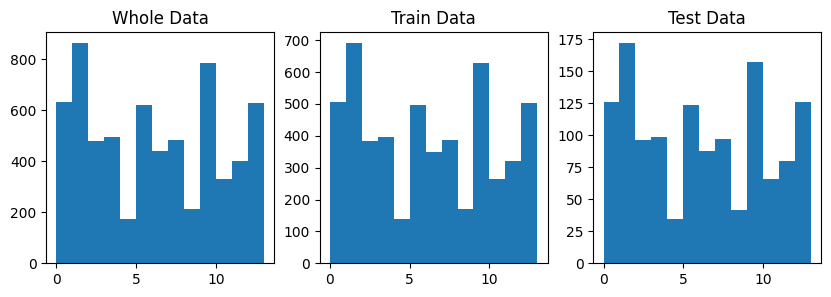

In [25]:
plt.figure(figsize=(10,3))

data = [train_dataset.labels.index(i) for i in train_dataset.targets]

plt.subplot(1, 3, 1)
plt.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plt.title("Whole Data")

plt.subplot(1, 3, 2)
data = [i[1] for i in train_dataset]
plt.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plt.title("Train Data")

plt.subplot(1, 3, 3)
test_dataset = KenyanFood13Dataset(TrainingConfiguration(), SystemConfiguration(), train=False, presized=True)
data = [i[1] for i in test_dataset]
plt.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plt.title("Test Data")

plt.show()

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [ ]:
def train(train_config: TrainingConfiguration, epoch_idx: int) -> (float, float):
    
    # Change model in training mode
    train_config.model.train()
    
    # To get batch loss
    batch_loss = np.array([])
    
    # To get batch accuracy
    batch_acc = np.array([])
    
    weights = train_config.weights.to(train_config.device)
    
    for batch_idx, (data, target) in enumerate(train_config.train_loader):
        # Clone target
        idx_target = target.clone()
        
        # Send data to device (mandatory if GPU has to be used)
        data = data.to(train_config.device)
        
        # Send target to device
        target = target.to(train_config.device)
        
        # Reset parameter gradient to zero
        train_config.optimizer.zero_grad()
        
        # Forward pass to the model
        output = train_config.model(data)
        
        # Croos entropy loss
        loss = torch.nn.functional.cross_entropy(output, target, weight=weights)
        
        # Find gradients w.r.t training parameters
        loss.backward()
        
        # Update parameters using gradients
        train_config.optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Get probability score using softmax
        prob = torch.nn.functional.softmax(output, dim=1)
        
        # Get the index of the max probability
        pred = prob.data.max(dim=1)[1]
        
        # Correct prediction
        correct = pred.eq(target).sum().cpu()
        
        # Accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
        
        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            total_batch = epoch_idx * len(train_config.train_loader.dataset) / train_config.batch_size + batch_idx
            
            if train_config.tb_writer != None:
                train_config.tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
                train_config.tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)
    
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    
    return epoch_loss, epoch_acc

In [ ]:
def validate(train_config: TrainingConfiguration) -> (float, float):
    
    # Change model in validation mode
    train_config.model.eval()
    
    test_loss = 0
    
    count_correct_predictions = 0
    
    weights = train_config.weights.to(train_config.device)
    
    for _, (data, target) in enumerate(train_config.test_loader):
        idx_target = target.clone()
        
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = train_config.model(data)
        
        test_loss += torch.nn.functional.cross_entropy(output, target, weight=weights).item()
        
        prob = torch.nn.functional.softmax(output, dim=1)
        
        pred = prob.data.max(dim=1)[1]
        
        count_correct_predictions += pred.cpu().eq(idx_target).sum()
        
        test_loss = test_loss / len(train_config.test_loader)
        
        accuracy = 100. * count_correct_predictions / len(train_config.test_loader.dataset)
        
        return test_loss, accuracy/100.0

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [16]:
'''
# calculate mean,std of the whole training set
tc_1 = TrainingConfiguration()
# Whole dataset -1
tc_1.test_size = 1 
df =  KenyanFood13Dataset(tc_1,SystemConfiguration())
t_f =transforms.ToTensor ()  

imgs_tensor = []
imgs_tensor_s = []
for img,label in df:
    imgs_tensor.append(t_f(img).mean((1,2)))
    imgs_tensor_s.append(t_f(img).std((1,2)))

np_mean = np.array([i.numpy() for i in imgs_tensor])
np_std = np.array([i.numpy() for i in imgs_tensor_s])
np_mean.mean((0)), np_std.mean((0))
'''
def get_mean_std(train_config: TrainingConfiguration, system_config: SystemConfiguration=SystemConfiguration):
    # Calculated from the train dataset
    mean = [0.5672454, 0.4663325, 0.3658769]
    std = [0.25292033, 0.26075897, 0.26472265]
    
    return mean, std

In [17]:
def image_preprocess_transforms():
    preprocess = transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    
    return preprocess

In [18]:
def image_common_transforms(mean, std):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess, 
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms

In [19]:
def data_augmentation_preprocess(mean, std):
    initial_transform = transform.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90)
    ])
    
    common_transforms = image_common_transforms(mean, std)
    
    aug_transforms = transforms.Compose([
        initial_transforms, 
        transforms.RandomChoice([
            AutoAugment(AutoAugmentPolicy.CIFAR10),
            AutoAugment(AutoAugmentPolicy.IMAGENET),
            transforms.TrivialAugmentWide()
        ]),
        transforms.RandomGrayscale(p=0.01),
        common_transforms
    ])
    
    return aug_transforms

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**